<a href="https://colab.research.google.com/github/egorssed/Galaxy_modelling_VAE/blob/main/Decoder_fitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
import matplotlib as mpl
import keras.backend as K
import tensorflow as tf
from tensorflow.python.ops import math_ops
from tqdm import tqdm
from google.colab import drive
drive.mount('/content/drive')
Folder='/content/drive/My Drive/TP4b/'

import sys
import os
sys.path.append(Folder+'/Modules')

#Utility modules
import Variational_autoencoder as VAE
import VAE_analysis as Analysis
import Image_Fits_Stats
import Visual_analysis

VAE.image_size=64
VAE.batch_size = 32
VAE.latent_dim = 64
VAE.start_lr = 1e-6

Mounted at /content/drive


In [2]:
from sklearn.model_selection import train_test_split


#We normalize the data to [0,1]

#Read the images and the features from the google drive
galaxy_images=np.load(Folder+'Data/Radial_cut=0.05/Images_MAD_Filtered.npy')
df=pd.read_csv(Folder+'Data/Radial_cut=0.05/Labels_MAD_Filtered.csv',index_col=0)

#Leave the number of images multiple of the batch_size
Size_of_dataset=len(galaxy_images[:-(len(galaxy_images)%VAE.batch_size)])
Number_of_batches=Size_of_dataset//VAE.batch_size
df=df.iloc[:Size_of_dataset]
df['Noise_sigma']=df['Noise_sigma']/df['max_I']
galaxy_images=galaxy_images[:Size_of_dataset]

#Bring images to a proper tensorial form
gal_dataset_images=np.reshape(VAE.normalize_image(copy.deepcopy(galaxy_images)), 
                              (len(galaxy_images), galaxy_images.shape[1], galaxy_images.shape[2], 1)).astype('float32')
#Separate the features we are eager to predict in the latent space
Features=['max_I','Noise_sigma']

#Extract test dataset
x_train,x_test,y_train,y_test= train_test_split(gal_dataset_images, df[Features].astype('float32'), test_size=round(0.05*Number_of_batches)*VAE.batch_size,random_state=42)
#Extract train and validation datasets
x_train, x_val , y_train, y_val= train_test_split(x_train, y_train, test_size=round(0.05*Number_of_batches)*VAE.batch_size,random_state=42)
#All the sets have number of galaxies which is a multiple of the batch size (32)
#The random_state is fixed so the split is reproducible yet random

In [3]:
Features_number=len(Features)
Features_means=df[Features].mean(axis=0)
Features_stds=df[Features].std(axis=0)

def make_labeled_images(x,labels):
  res=np.zeros((len(x),x.shape[1]+1,x.shape[2],1))
  res[:,:-1,:,:]=x
  res[:,-1,:Features_number,0]=labels
  return res.astype('float32')

x_train_labeled=make_labeled_images(x_train,y_train)
x_test_labeled=make_labeled_images(x_test,y_test)
x_val_labeled=make_labeled_images(x_val,y_val)
galaxies_labeled=make_labeled_images(gal_dataset_images,df[Features])

In [4]:
#Data to estimate model's quality

COSMOS_indices_to_compare=np.zeros(8,dtype=int)
COSMOS_indices_to_compare=[33671, 25576, 45805, 31577, 41707, 19844, 13628,  8624]
images_to_compare_indices=df[np.isin(df.COSMOS_index,COSMOS_indices_to_compare)].index
imgs=np.zeros((32,64,64,1))
imgs[:8] = gal_dataset_images[images_to_compare_indices]
labels_to_compare=np.ones((32,2))
labels_to_compare[:8]=df.iloc[images_to_compare_indices][['max_I','Noise_sigma']]
n_compare = 8

In [5]:
fit_starlets=np.load(Folder+'Data/Radial_cut=0.05/Benchmark data/fit_starlets.npy',allow_pickle=True)
imgs_starlets_fitted=np.concatenate(fit_starlets[0]).reshape(8,64,64)
fit_shapelets=np.load(Folder+'Data/Radial_cut=0.05/Benchmark data/fit_shapelets.npy',allow_pickle=True)
imgs_shapelets_fitted=np.concatenate(fit_shapelets[0]).reshape(8,64,64)

# Neural Nets

In [8]:
models,_,_,_=VAE.get_VAE('softplus','mse',beta_vae=1e-2)
models['vae'].load_weights('/content/drive/My Drive/TP4b/'\
                                  +'Models/Pretrain_MAE_beta=1e-2_epoch_130/3*MSE_beta=1e-2/'+'epoch_{}/Model'.format(80))

In [9]:
z_means=models['z_meaner'].predict(gal_dataset_images)
z_log_vars=models['z_log_varer'].predict(gal_dataset_images)

In [10]:
latent_average=z_means.mean(axis=0)

In [11]:
decoded=models['decoder'].predict(models['z_meaner'].predict(gal_dataset_images))
std_of_mu=z_means.std(axis=0)
mean_of_var=(np.exp(z_log_vars/2)).mean(axis=0)
ratio=std_of_mu/mean_of_var

KeyboardInterrupt: ignored

In [12]:
from sklearn.decomposition import PCA
pca = PCA(n_components=64)
pca.fit_transform(z_means)
Principal_components=pca.transform(z_means)
Principal_means=Principal_components.mean(axis=0)
Principal_stds=Principal_components.std(axis=0)

In [13]:
def PC_from_z(z):
    return np.dot(z - pca.mean_, pca.components_.T)

def z_from_PC(PC):
    return tf.tensordot(math_ops.cast(PC,'double'), math_ops.cast(pca.components_,'double'),axes=1) + math_ops.cast(pca.mean_,'double')

## Fitting

In [14]:
from scipy.optimize import curve_fit,minimize

def MSE_from_z(latent_z,image):

  
    z=K.reshape(latent_z,shape=(1,64))
    image_pred=models['decoder'](z)
    
    y_true=math_ops.cast(K.reshape(image,shape=(1,64*64)),'double')
    y_pred=math_ops.cast(K.reshape(image_pred,shape=(1,64*64)),'double')

    return K.eval(K.sum(K.square(y_true-y_pred)/4096,axis=-1))[0]


def MSE_from_PCA(PC,image):

    z=K.reshape(z_from_PC(PC),shape=(1,64))
    image_pred=models['decoder'](z)
    
    y_true=math_ops.cast(K.reshape(image,shape=(1,64*64)),'double')
    y_pred=math_ops.cast(K.reshape(image_pred,shape=(1,64*64)),'double')

    return K.eval(K.sum(K.square(y_true-y_pred)/4096,axis=-1))[0]

def calculate_gradient_from_z(latent_z,image):
    image_true=tf.constant(image.reshape((1,64,64,1)))
    z=tf.constant(K.reshape(latent_z,shape=(1,64)))
    with tf.GradientTape(watch_accessed_variables=False, persistent=True) as g:
      g.watch(z)
      image_pred=models['decoder'](z)

      y_true=math_ops.cast(K.reshape(image_true,shape=(1,64*64)),'double')
      y_pred=math_ops.cast(K.reshape(image_pred,shape=(1,64*64)),'double')
      
      #chi_squared
      Loss=K.sum(K.square(y_true-y_pred),axis=-1)/4096

    return K.eval(g.gradient(Loss, z)[0])

def calculate_gradient_from_PCA(PC,image):
    image_true=tf.constant(image.reshape((1,64,64,1)))
    PC=tf.constant(K.reshape(PC,shape=(1,64)))
    with tf.GradientTape(watch_accessed_variables=False, persistent=True) as g:
      g.watch(PC)
      
      z=K.reshape(z_from_PC(PC),shape=(1,64))
      image_pred=models['decoder'](z)

      y_true=math_ops.cast(K.reshape(image_true,shape=(1,64*64)),'double')
      y_pred=math_ops.cast(K.reshape(image_pred,shape=(1,64*64)),'double')
      
      #chi_squared
      Loss=K.sum(K.square(y_true-y_pred),axis=-1)/4096

    return K.eval(g.gradient(Loss, PC)[0])


def get_z_fit(image):
    z=latent_average.reshape((1,64))
    res=minimize(fun=MSE_from_z,x0=z,args=image,jac=calculate_gradient_from_z)
    return res

def get_PCA_fit(image):
    PC=Principal_means.reshape((1,64))
    res=minimize(fun=MSE_from_PCA,x0=PC,args=image,jac=calculate_gradient_from_PCA)
    return res


def compare_fits(image):

    #Decoder fit
    res_z_fit=get_z_fit(image)
    res_PC_fit=get_PCA_fit(image)
    #Vae reconstruction
    vae_z=K.eval(models['z_meaner'](K.reshape(image,shape=(1,64,64,1)))[0])
    vae_PC=pca.transform(vae_z.reshape(1,64))
    #Chameleon+Sersic
    fit_ChS,_=get_Chameleon_Sersic_fit(image[:,:,0])
    ChS_image=Image_Fits_Stats.Chameleon_Sersic(xdata,*fit_ChS).reshape(64,64)
    Loss_ChS=K.eval(K.sum(K.square(ChS_image.reshape(64*64)-image.reshape(64*64)),axis=-1))/4096

    return res_z_fit.fun,res_PC_fit.fun,MSE_from_z(vae_z,image),MSE_from_PCA(vae_PC,image),Loss_ChS,res_z_fit.x,res_PC_fit.x,vae_z,vae_PC,fit_ChS

In [15]:
!pip install lmfit

     |████████████████████████████████| 307kB 4.2MB/s 
     |████████████████████████████████| 61kB 5.4MB/s 
     |████████████████████████████████| 256kB 7.6MB/s 
  Created wheel for lmfit: filename=lmfit-1.0.2-cp37-none-any.whl size=85278 sha256=b4bb07625e8f86c3b161765302ad01ffc1b3439a63d945fc1c3c91d42f1a0019
  Stored in directory: /root/.cache/pip/wheels/d4/5e/db/d9f5987d9f15bf910feb5e0274ac601d5f2161dc78aedfacfa
  Created wheel for asteval: filename=asteval-0.9.23-cp37-none-any.whl size=17432 sha256=a5e240d546c8ed0abcd7ce6ee01857d1efb9dc5f2827fc6f9c9a9eb9539759cd
  Stored in directory: /root/.cache/pip/wheels/56/d6/43/4b5d8a9fd98b976031768673658c8b8d08dc9dcc0fa1907ad0
Successfully built lmfit asteval


In [16]:
import lmfit
import tensorflow as tf

x = np.linspace(0, 64, 64)
y = np.linspace(0, 64, 64)
X, Y = np.meshgrid(x, y)
# We need to ravel the meshgrids of X, Y points to a pair of 1-D arrays.
xdata = np.vstack((X.ravel(), Y.ravel()))

def fit_image_LMA(image,xdata,func,initial_guess,lower_bounds,upper_bounds):

    def residual(pars,xdata, data=None):
        fit=np.zeros(len(pars.items()))
        for i,item in enumerate(pars.items()):
            name,param=item
            fit[i]=param.value
        model=func(xdata,*fit)
        #Chi_sq
        return K.square(model-data)

    fit_params = lmfit.Parameters()

    for i in range(len(initial_guess)):
        fit_params.add(name='par{}'.format(i),value=initial_guess[i], max=upper_bounds[i], min=lower_bounds[i])

    out = lmfit.minimize(residual, fit_params,args=(xdata,),
                   kws={'data': image.ravel()})

    fit=np.zeros(len(out.params.items()))
    errs=np.zeros(len(out.params.items()))
    for i,item in enumerate(out.params.items()):
        name,param=item
        fit[i]=param.value
        errs[i]=param.stderr

    return fit,errs

In [202]:
def get_Chameleon_Sersic_fit(image):
  func=Image_Fits_Stats.Chameleon_Sersic
  n_initial=1
  k=2*n_initial-0.324
  initial_guess=np.array([image.max()*20,2,0.1,0.88,0,
                             image.max()*np.exp(-k),10,n_initial,0.88,0,
                             image.shape[1]/2,image.shape[0]/2])
  lower_bounds=np.array([image.max()*1e-5,0,0,0.01,-np.pi/2,
                           0,0,0.5,0.01,-np.pi/2,
                           0,0])
  upper_bounds=np.array([np.inf,np.inf,1,1,np.pi/2,
                           image.max(),np.min(image.shape)/2,6,1,np.pi/2,
                           image.shape[1],image.shape[0]])
  
  popt, pcov = curve_fit(f=func, xdata=xdata,
                               ydata=image.ravel(),
                               p0=initial_guess,
                               bounds=(lower_bounds,upper_bounds))
  return popt,pcov
  #return fit_image_LMA(image,xdata,func,initial_guess,lower_bounds,upper_bounds)

## Comparison of different models


In [ ]:
fit_columns=['chi_sq_fit_decoder','chi_sq_vae','chi_sq_ChS','fit_z','encoded_z','ChS_fit']

fit_columns=['MSE_fit_z','MSE_fit_PCA','MSE_vae_z','MSE_vae_PC','MSE_ChS','fit_z','fit_PC','vae_z','vae_PC','fit_ChS']
df_fit=pd.DataFrame(columns=fit_columns)
for index in tqdm(range(8)):
    results=compare_fits(imgs[index])
    df_fit=df_fit.append(pd.Series(results,index=fit_columns),ignore_index=True)

100%|██████████| 8/8 [04:20<00:00, 32.61s/it]


In [ ]:
imgs_z_fitted=models['decoder'].predict(np.concatenate(df_fit['fit_z'],axis=0).reshape((len(df_fit),64)))
imgs_PCA_fitted=models['decoder'].predict(z_from_PC(np.concatenate(df_fit['fit_PC'],axis=0).reshape((len(df_fit),64))))
fit_imgs=np.zeros((8,5,64,64,1))
for i in range(len(df_fit)):
  image_ChS=Image_Fits_Stats.Chameleon_Sersic(xdata,*df_fit['fit_ChS'].iloc[i]).reshape((1,64,64,1))
  fit_imgs[i]=[imgs[i],imgs_PCA_fitted[i],imgs_starlets_fitted[i].reshape(64,64,1),imgs_shapelets_fitted[i].reshape(64,64,1),image_ChS.reshape(64,64,1)]

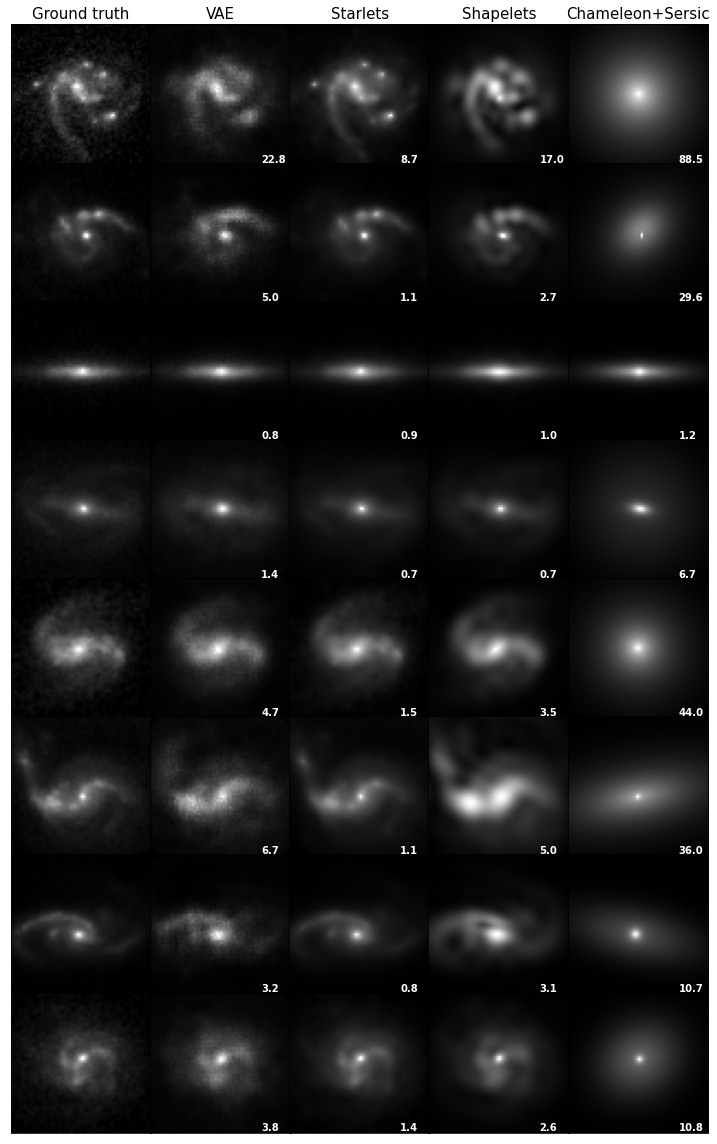

In [ ]:
fig,ax=plt.subplots(8,5,figsize=(12,16))

fig_titles=['Ground truth','VAE','Starlets','Shapelets','Chameleon+Sersic']

for sample in range(8):
  for method in range(5):
    ax[sample,method].imshow(fit_imgs[sample,method,:,:,0],cmap='gray')
    ax[sample,method].set_xticks([])
    ax[sample,method].set_yticks([])
    if method>0:
      MSE=K.eval(K.mean(K.square(fit_imgs[sample,method,:,:,0]-fit_imgs[sample,0,:,:,0])))
      ax[sample,method].text(50, 62,'{:.1f}'.format(MSE*1e+4), color='white',size=10,weight="bold")

for method in range(5):
    ax[0,method].set_title(fig_titles[method],fontsize=15)

plt.tight_layout(w_pad=-14,h_pad=-0.6)

# Reconstruction residuals

In [ ]:
div_cmap=sns.diverging_palette(250, 10, s=99, l=50, sep=20, n=6, center='light', as_cmap=True)

In [ ]:
def norm(tensor):
    image=tensor.copy()
    image/=np.abs(image).max()
    #image[image>0]/=image.max()
    #image[image<0]/=np.abs(image.min())
    return image

In [ ]:
residuals=fit_imgs[:,0,:,:,0]-fit_imgs[:,1,:,:,0]

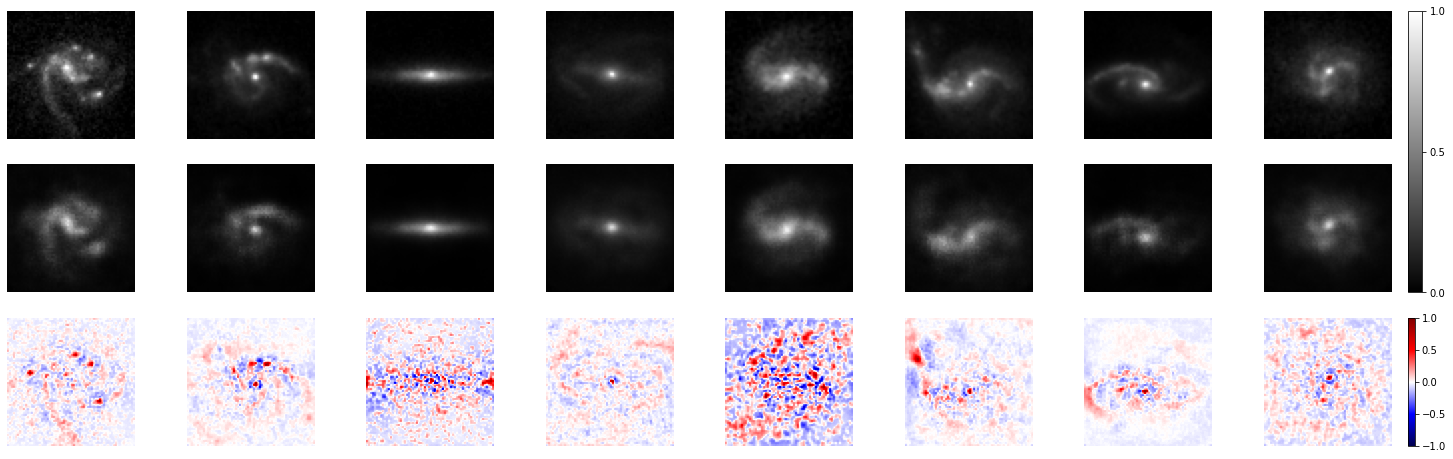

In [ ]:
from matplotlib import cm
fig,ax_images = plt.subplots(3,8,figsize=(30,8))


for i in range(8):
  for row in range(2):
    if (i==0) and (row==0):
      im=ax_images[row,i].imshow(fit_imgs[i,row,:,:,0],cmap='gray',vmin=0,vmax=1)
    else:
      ax_images[row,i].imshow(fit_imgs[i,row,:,:,0],cmap='gray',vmin=0,vmax=1)
    ax_images[row,i].axis('off')


for i in range(8):
  non_neg_im=fit_imgs[i,0,:,:,0].copy()
  non_neg_im[non_neg_im<0]=0
  sigma=np.sqrt(non_neg_im/2028+labels_to_compare[i,1]**2)
  im=ax_images[2,i].imshow(norm(residuals[i,:,:]),cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0,-1,1))
  #im=ax[i].imshow((fit_imgs[i,0]-fit_imgs[i,1])[:,:,0],cmap=div_cmap,norm=mpl.colors.TwoSlopeNorm(0))
  ax_images[2,i].axis('off')

ax_top = ax_images[:2]
ax_btm = ax_images[2]
## normalize colors to minimum and maximum values of dataset
norm_top = mpl.colors.Normalize(vmin=0, vmax=1)
norm_btm = mpl.colors.Normalize(vmin=-1, vmax=1)

mtop = cm.ScalarMappable(cmap=cm.get_cmap('gray'), norm=norm_top)
mbtm = cm.ScalarMappable(cmap=cm.get_cmap('seismic'), norm=norm_btm)
for m in (mtop, mbtm):
    m.set_array([])


cbar_top = fig.colorbar(mtop, ax=ax_top, orientation='vertical', shrink=1,pad=0.01) #, cax=cax_top)
cbar_top.set_ticks([0,0.5,1])
cbar_btm = fig.colorbar(mbtm, ax=ax_btm, orientation='vertical', shrink=1,pad=0.01) #, cax=cax_btm)
cbar_btm.set_ticks([-1,-0.5,0,0.5,1])

plt.show()
plt.close(fig)

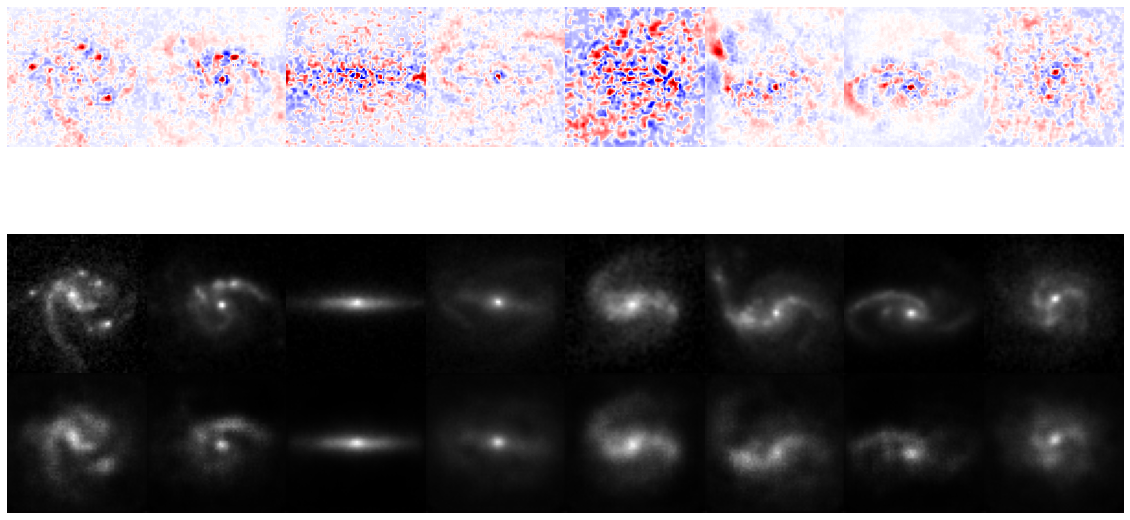

In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(20,20))


# Set up figure and image grid

ax_images = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(2,8),
                 axes_pad=0)

for i in range(8):
  for row in range(2):
    if (i==0) and (row==0):
      im=ax_images[8*row+i].imshow(fit_imgs[i,row,:,:,0],cmap='gray',vmin=0,vmax=1)
    else:
      ax_images[8*row+i].imshow(fit_imgs[i,row,:,:,0],cmap='gray',vmin=0,vmax=1)
    ax_images[8*row+i].axis('off')


ax = ImageGrid(fig, 211,          # as in plt.subplot(111)
               nrows_ncols=(1,8),
               axes_pad=0)

for i in range(8):
  non_neg_im=fit_imgs[i,0,:,:,0].copy()
  non_neg_im[non_neg_im<0]=0
  sigma=np.sqrt(non_neg_im/2028+labels_to_compare[i,1]**2)
  im=ax[i].imshow(norm(residuals[i,:,:]),cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0,-1,1))
  #im=ax[i].imshow((fit_imgs[i,0]-fit_imgs[i,1])[:,:,0],cmap=div_cmap,norm=mpl.colors.TwoSlopeNorm(0))
  ax[i].axis('off')


plt.show()

In [ ]:
import seaborn as sns
sns.choose_diverging_palette()

interactive(children=(IntSlider(value=220, description='h_neg', max=359), IntSlider(value=10, description='h_p…

[(0.2519971417644415, 0.4987337088076726, 0.5751602783606602),
 (0.43156001218774975, 0.6160490836499025, 0.6735874169971766),
 (0.611122882611058, 0.7333644584921324, 0.7720145556336929),
 (0.7906857530343663, 0.8506798333343624, 0.8704416942702093),
 (0.95, 0.95, 0.95),
 (0.9282549678814984, 0.7863704363662967, 0.7963965173228867),
 (0.9022582584936525, 0.6005186021022944, 0.622400049291663),
 (0.8762615491058064, 0.4146667678382919, 0.44840358126043944),
 (0.8510408608937171, 0.23436274952246883, 0.2796010376480583)]

In [44]:
PCA_fits_imgs=np.zeros((len(imgs),64))
for i in range(8):
  PCA_fit[i]=get_PCA_fit(imgs[i]).x

NameError: ignored

In [45]:
imgs_PCA_fitted=models['decoder'].predict(z_from_PC(np.concatenate(PCA_fits_imgs,axis=0).reshape((len(imgs),64))))

In [72]:
flatten_imgs_fits=imgs_PCA_fitted[:8].reshape((8,64*64))
reconst_MSE=np.zeros((8,64*64,2))
reconst_MSE[:,:,0]=imgs[:8].reshape((8,64*64))
reconst_MSE[:,:,1]=K.eval(K.square(flatten_imgs_fits-reconst_MSE[:,:,0]))

In [169]:
index=0
intensities=reconst_MSE[index,:,0]
squared_errors=reconst_MSE[index,:,1]
squared_errors=squared_errors[np.argsort(intensities)]
intensities=intensities[np.argsort(intensities)]

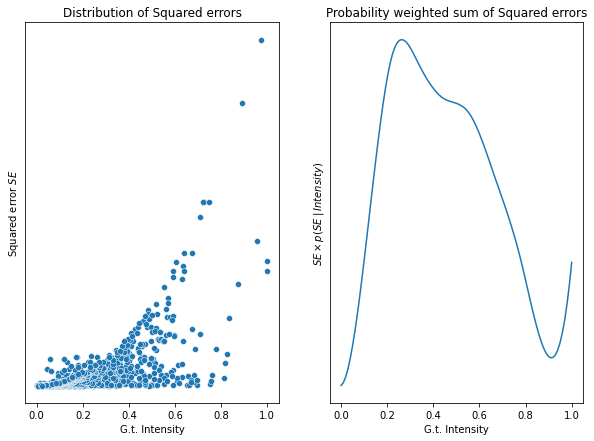

In [199]:
import seaborn as sns
from scipy.interpolate import interp1d

bins=10
binned_distribution=np.zeros(bins)
intensities_linspace=np.linspace(0,1,bins)
for i in range(len(intensities)-1):
  bin=np.where(intensities[i]<intensities_linspace)[0][0]
  binned_distribution[bin]+=squared_errors[i]
binned_distribution[-1]+=squared_errors[-1]

#to get p(SE|I)*SE
binned_distribution/=4096

f_cubic = interp1d(intensities_linspace, binned_distribution, kind='cubic')
new_intensities_linspace = np.linspace(0, 1, num=100)

fig,ax=plt.subplots(1,2,figsize=(10,7))


data=reconst_MSE[index]
sns.scatterplot(x='Intensity',y='Squared error',data=pd.DataFrame(data=data[data[:,0]!=0],columns=['Intensity','Squared error']),ax=ax[0])
ax[0].set_ylabel('Squared error '+r'$\mathit{SE}$')
ax[0].set_xlabel('G.t. Intensity')
ax[0].set_yticks([])
ax[0].set_title('Distribution of Squared errors')


ax[1].plot(new_intensities_linspace,f_cubic(new_intensities_linspace))
ax[1].set_ylabel(r'$SE \times p(SE \: |\: Intensity)$')
ax[1].set_yticks([])
ax[1].set_xlabel('G.t. Intensity')
ax[1].set_title('Probability weighted sum of Squared errors')
plt.show()

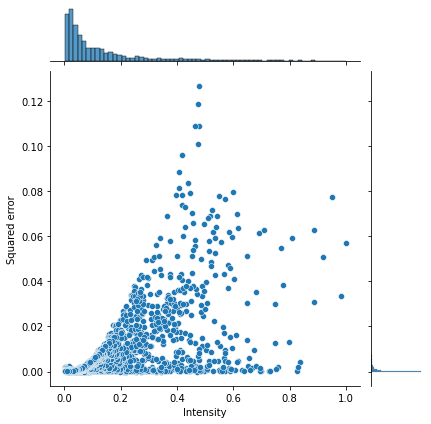

In [65]:
index=4
data=reconst_MSE[index]
sns.jointplot(x='Intensity',y='Squared error',data=pd.DataFrame(data=data[data[:,0]!=0],columns=['Intensity','Squared error']))

In [ ]:
index=4
data=reconst_MSE[index]
sns.jointplot(x='Intensity',y='Squared error',data=pd.DataFrame(data=data[data[:,0]!=0],columns=['Intensity','Squared error']))

In [53]:
reconst_MSE_df

,Intensity,Squared error
0,0.000000,5.445973e-04
1,0.000000,8.302769e-05
2,0.003568,2.084728e-06
3,0.000000,5.798121e-05
4,0.000000,6.846241e-05
...,...,...
4091,0.000000,6.855884e-05
4092,0.006533,6.615868e-07
4093,0.000000,1.308511e-05
4094,0.016937,5.174139e-05


In [38]:
PCA_fit=get_PCA_fit(imgs[0])

In [42]:
PCA_fit.x.shape

(64,)

In [ ]:
def get_PCA_fit(image):
    PC=Principal_means.reshape((1,64))
    res=minimize(fun=MSE_from_PCA,x0=PC,args=image,jac=calculate_gradient_from_PCA)
    return res


# Fitting Lensing

In [ ]:
fit_starlets=np.load(Folder+'Data/Radial_cut=0.05/Benchmark data/fit_starlets.npy',allow_pickle=True)
imgs_starlets_fitted=np.concatenate(fit_starlets[0]).reshape(8,64,64)
fit_shapelets=np.load(Folder+'Data/Radial_cut=0.05/Benchmark data/fit_shapelets.npy',allow_pickle=True)
imgs_shapelets_fitted=np.concatenate(fit_shapelets[0]).reshape(8,64,64)

In [ ]:
lensed_imgs=np.load(Folder+'Data/Radial_cut=0.05/Benchmark data/lensed_benchmarks.npy',allow_pickle=True)
fitted_lenses_imgs=np.load(Folder+'Data/Radial_cut=0.05/Benchmark data/fitted_lensed_benchmarks.npy')

In [ ]:
fitted_lenses_imgs.shape

(8, 64, 64)

In [ ]:
rotated_lenses=np.zeros((8,64,64,1))
for i in range(8):
    image=lensed_imgs[i,:,:].T
    rotated_lenses[i,:,:,:]=image.reshape((64,64,1))

Maximal brightness 0.9854741711809011


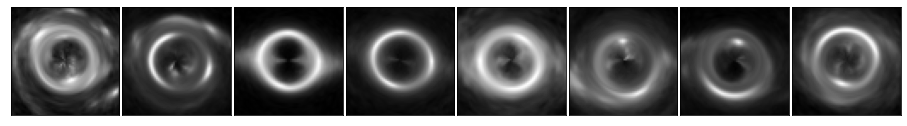

In [ ]:
Analysis.plot_galaxies(rotated_lenses)

Maximal brightness 1.009357213973999


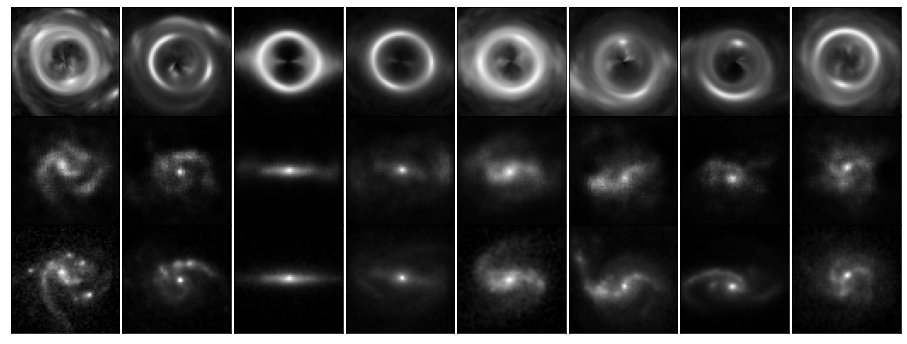

In [ ]:
Analysis.plot_galaxies(rotated_lenses,fitted_lenses_imgs.reshape(8,64,64,1),imgs[:8])

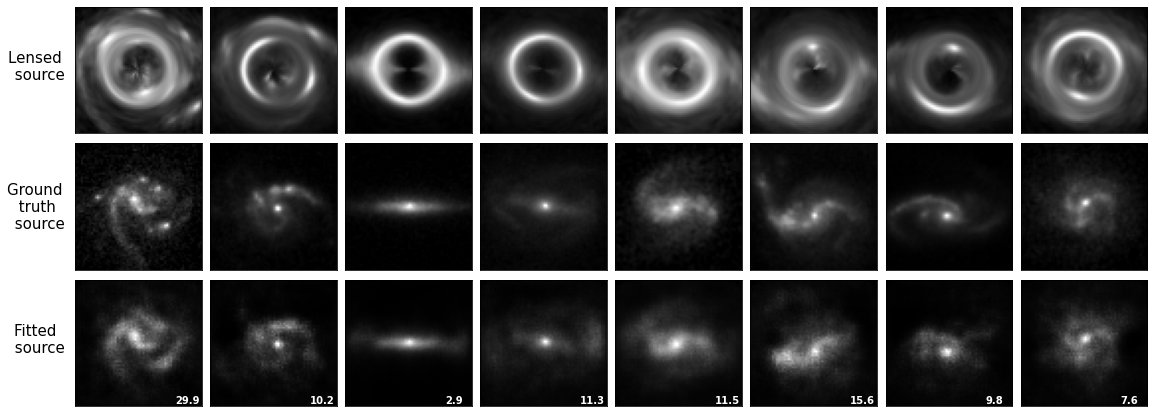

In [ ]:
fig,ax=plt.subplots(3,8,figsize=(16,6))

for i in range(8):
  ax[0,i].imshow(rotated_lenses[i,:,:,0],cmap='gray')
  ax[1,i].imshow(imgs[i,:,:,0],cmap='gray')
  ax[2,i].imshow(fitted_lenses_imgs[i,:,:],cmap='gray')
  MSE=K.eval(K.mean(K.square(imgs[i,:,:,0]-fitted_lenses_imgs[i,:,:])))
  ax[2,i].text(50, 62,'{:.1f}'.format(MSE*1e+4), color='white',size=10,weight="bold")
  for j in range(3):
    ax[j,i].set_xticks([])
    ax[j,i].set_yticks([])

ax[1,0].set_ylabel('Ground \n truth \n source',fontsize=15,rotation=0)
ax[1,0].yaxis.set_label_coords(-0.3,0.3)
ax[0,0].set_ylabel('Lensed \n source',fontsize=15,rotation=0)
ax[0,0].yaxis.set_label_coords(-0.3,0.4)
ax[2,0].set_ylabel('Fitted \n source',fontsize=15,rotation=0)
ax[2,0].yaxis.set_label_coords(-0.3,0.4)

plt.tight_layout(h_pad=0,w_pad=0)

In [ ]:
fitted_lenses_imgs.reshape

<function ndarray.reshape>

# Sersic prediction from PCA

In [34]:
import time as measure_time
def get_timed_results(func,*args):
  start = measure_time.time()
  res=func(*args)
  end = measure_time.time()

  return (end-start),res

## Sersic

In [203]:
time,fit_ChS=get_timed_results(get_Chameleon_Sersic_fit,x_val[i,:,:,0])

In [204]:
time

7.292721271514893

In [205]:
Sersic_val_time

array([2.2694726 , 5.1835568 , 0.54904699, ..., 0.        , 0.        ,
       0.        ])

In [201]:
Sersic_val=np.zeros((len(x_val),12))
Sersic_val_time=np.zeros(len(x_val))
for i in tqdm(range(len(x_val))):
    time,fit_ChS=get_timed_results(get_Chameleon_Sersic_fit,x_val[i,:,:,0])

    Sersic_val_time[i]=time
    Sersic_val[i]=fit_ChS[0]




  0%|          | 0/1280 [00:00<?, ?it/s]


  0%|          | 1/1280 [00:02<48:22,  2.27s/it]


  0%|          | 2/1280 [00:07<1:07:04,  3.15s/it]


  0%|          | 3/1280 [00:08<50:28,  2.37s/it]  


  0%|          | 4/1280 [00:08<39:36,  1.86s/it]


  0%|          | 5/1280 [01:02<6:09:18, 17.38s/it]


  0%|          | 6/1280 [01:03<4:25:54, 12.52s/it]


  1%|          | 7/1280 [01:08<3:37:11, 10.24s/it]


  1%|          | 8/1280 [02:03<8:21:21, 23.65s/it]


  1%|          | 9/1280 [02:09<6:31:06, 18.46s/it]


  1%|          | 10/1280 [02:47<8:32:26, 24.21s/it]


  1%|          | 11/1280 [02:48<6:05:40, 17.29s/it]


  1%|          | 12/1280 [02:49<4:20:58, 12.35s/it]


  1%|          | 13/1280 [02:50<3:08:04,  8.91s/it]


  1%|          | 14/1280 [02:50<2:15:44,  6.43s/it]


  1%|          | 15/1280 [02:51<1:41:10,  4.80s/it]


  1%|▏         | 16/1280 [03:03<2:21:58,  6.74s/it]


  1%|▏         | 17/1280 [03:57<7:25:17, 21.15s/it]


  1%|▏         | 18/1280 [04:52<10:55:00, 31.14s/

KeyboardInterrupt: ignored

In [ ]:
Sersic_test=np.zeros((len(x_test),12))
Sersic_test_time=np.zeros(len(x_test))
for i in tqdm(range(len(x_test))):
    time,fit_ChS=get_timed_results(get_Chameleon_Sersic_fit,x_test[i,:,:,0])

    Sersic_test_time[i]=time
    Sersic_test[i]=fit_ChS